In [158]:
import os
import json
from json import JSONDecoder
import numpy as np
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [3]:
import warnings
warnings.filterwarnings("ignore")

#### Load data

In [4]:
data_folder = "data"
trainA_file = os.path.join(data_folder, 'trainA.json')
trainB_file = os.path.join(data_folder, 'trainB.json')
test_file = os.path.join(data_folder, 'test.json')

train_feature_f = os.path.join(data_folder, 'task3_train_feature.txt')
test_feature_f = os.path.join(data_folder, 'task3_test_feature.txt')

word2idx_f = os.path.join(data_folder, 'word2idx.json')
pos2idx_f = os.path.join(data_folder, 'pos2idx.json')
word_embeds_f = os.path.join(data_folder, 'word_embedding.npy')
pos_embeds_f = os.path.join(data_folder, 'pos_embedding.npy')

In [5]:
def load_data(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
        dataList=data['data']
    return dataList

def load_seq_feats(filename):
    with open(filename,'r')as f:
        test_feature=f.read()
    test_feature=JSONDecoder().decode(test_feature)
    return test_feature

In [6]:
trainA = load_data(trainA_file)[:3450]
validA = load_data(trainA_file)[3450:]
trainB = load_data(trainB_file)[:3450]
validB = load_data(trainB_file)[3450:]
test = load_data(test_file)
print("#train:", len(trainA),"#valud:", len(validA),"#test:", len(test))

#train: 3450 #valud: 384 #test: 784


In [7]:
train_feature = load_seq_feats(train_feature_f)
test_feature = load_seq_feats(test_feature_f)

load word and pos embeddings

In [8]:
def load_dict(fname):
    with open(fname, 'r') as file:
        dictionary = json.load(file)
    return dictionary

In [9]:
word2idx = load_dict(word2idx_f)
pos2idx = load_dict(pos2idx_f)
vocab_size = len(word2idx)
print("vocab size:", vocab_size)

word_embedding = np.load(word_embeds_f)
pos_embedding = np.load(pos_embeds_f)

vocab size: 12656


In [10]:
print(word_embedding.shape, pos_embedding.shape)

(12656, 700) (28, 28)


#### Positional Encoding  
$P E_{2 i}(p)=\sin \left(p / 10000^{2 i / d_{model}}\right)$   
$P E_{2 i+1}(p)=\cos \left(p / 10000^{2 i / d_{model}}\right)$

In [193]:
# 返回的是x+pe
def positional_enc(x, dim_model, max_len=5000):
    base = 10000
    sentence_len = x.size(1)
    pe_vec = torch.zeros(max_len, dim_model)
    p = torch.arange(0., max_len).unsqueeze(1)
    frac = torch.exp(torch.arange(0., dim_model, 2) * -(math.log(10000.0) / dim_model)) 
    pe_vec[:,0::2] = torch.sin(p)
    pe_vec[:,1::2] = torch.cos(p)
    pe_vec = pe_vec.unsqueeze(0)
    return x.float() + pe_vec[:,:sentence_len]

#### Attention
scaled dot product attention:
 $\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}\right) V$

In [324]:
def scaled_dot_product_attention(query, key, value, mask=None, dropout=0.1):
    dim_key = query.size(-1)
    attn = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(dim_key)
    if mask is not None:
        attn = scores.masked_fill(mask == 0, -1e9)
    attn_weights = F.softmax(attn, dim = -1)
    if dropout is not None:
        attn_weights = dropout(attn_weights)
    return torch.matmul(attn_weights, value), attn_weights

Self attention: K=V=Q  
each word in the sentence needs to undergo Attention computation, to capture the internal structure of the sentence

Multi-head Attention: query, key, and value first go through a linear transformation and then enters into Scaled-Dot Attention. Here, the attention is calculated h times, which allows the model to learn relevant information in different representative child spaces.  
When #head=1, it becomes a original self-attention layer.

In [326]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, num_heads, dim_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        # make sure input word embedding dimension divides by the number of desired heads
        assert dim_model % num_heads == 0
        # assume dim of key,query,values are equal
        self.dim_qkv = dim_model // num_heads
        
        self.dim_model = dim_model
        self.num_h = num_heads
        self.w_q = nn.Linear(dim_model, dim_model) # self.w_qs = nn.Linear(d_model, n_head * d_k) 
        self.w_k = nn.Linear(dim_model, dim_model) 
        self.w_v = nn.Linear(dim_model, dim_model)
        
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        self.layer_norm = nn.LayerNorm(dim_model)
        
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
            
        n_batch = query.size(0)
#         residual = query
        
        # linear projections: dim_model => num_h x dim_k 
        query = self.w_q(query).view(n_batch, -1, self.num_h, self.dim_qkv)
        key = self.w_k(key).view(n_batch, -1, self.num_h, self.dim_qkv)
        value = self.w_v(value).view(n_batch, -1, self.num_h, self.dim_qkv)
        
        # Apply attention on all the projected vectors in batch 
        x, self.attn = scaled_dot_product_attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # Concat(head1, ..., headh) 
        x = x.transpose(1, 2).contiguous().view(n_batch, -1, self.num_h * self.dim_qkv)
        
        x = nn.Linear(dim_model, dim_model, bias=False)(x)
#         x = self.layer_norm(x + residual)
        return x

#### Position-wise feed forward network

In [206]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu # bert uses gelu instead

    def forward(self, x):
        return self.w_2(self.dropout(self.activation(self.w_1(x))))

#### Add & Norm
`Residual connection`是对于较为深层的神经网络有比较好的作用，比如网络层很深时，数值的传播随着weight不断的减弱，`Residual connection`是从输入的部分，连到它输出层的部分，把输入的信息原封不动copy到输出的部分，减少信息的损失。
`layer-normalization`这种归一化层是为了防止在某些层中由于某些位置过大或者过小导致数值过大或过小，对神经网络梯度回传时有训练的问题，保证训练的稳定性。基本在每个子网络后面都要加上`layer-normalization`、加上`Residual connection`，加上这两个部分能够使深层神经网络训练更加顺利。  
(本实验中也许不需要)

In [261]:
class AddNorm(nn.Module):
    def __init__(self, size, dropout, eps=1e-6):
        super(AddNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(size))
        self.b_2 = nn.Parameter(torch.zeros(size))
        self.eps = eps
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        x = x.float()
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        norm = self.a_2 * (x - mean) / (std + self.eps) + self.b_2
        return x + self.dropout(sublayer(norm))

#### Encoder
self-attention layers: all of the keys, values and queries come from the previous layer in the encoder. Each position in the encoder can attend to all positions in the previous layer of the encoder.

In [249]:
# 一层Encoder: self-atten --> add&norm --> feed-forward --> add&norm
# 浅层网络可以去掉add&norm层？
class EncoderLayer(nn.Module):
    def __init__(self, size, attention, feed_forward, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.feed_forward = feed_forward
        self.self_atten = attention
        self.add_norm_1 = AddNorm(size, dropout)
        self.add_norm_2 = AddNorm(size, dropout)
        self.size = size

    def forward(self, x, mask=None):
        output = self.add_norm_1(x, lambda x: self.self_atten(x, x, x, mask))
        output = self.add_norm_2(output, self.feed_forward)
        return output

In [240]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([copy.deepcopy(layer) for _ in range(N)]) # clone the layer for N times
        self.norm = nn.LayerNorm(layer.size)

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

#### Classifier

In [350]:
class SoftMax(nn.Module):
    def __init__(self,n_input,n_out):
        super(SoftMax,self).__init__()
        self.fc = nn.Linear(n_input,n_out)
        self.softmax = nn.LogSoftmax(1)
        
    def forward(self, x):
        x = self.fc(x)
        y = self.softmax(x)
#         print(y)
        return y

#### Full Model

In [325]:
# single task
# embeding --> encoder --> linear --> softmax
class SelfAttenClassifier(nn.Module):
    def __init__(self, encoder, classifier):
        super(SelfAttenClassifier, self).__init__()
        self.encoder = encoder
        self.classifier = classifier
        
    def forward(self, input_embeds):
        batch_size = input_embeds.size(1)
        encoder_out = self.encoder(input_embeds)
        # Simply average the final sequence position representations to create a fixed size "sentence representation".
#         sentence_representation = tf.reduce_mean(encoder_output, axis=1)    # [batch_size, model_dim]
        feats = encoder_out.sum(dim=1)
#         print(encoder_out.size(), feats.size())
        outputs = self.classifier(feats)
        return outputs

###### TODO concatenate sentence embedding before classifier

##### TODO multi-task

### Train

prepare inputs

In [25]:
# vectorize sequences as inputs 
def seq_to_tensor(raw_sample,dim_model=728):
    seq_embed = torch.tensor([np.concatenate([word_embedding[word2idx[w]],pos_embedding[pos2idx[raw_sample["pos"][i]]]]) 
                       for i,w in enumerate(raw_sample["word"])])
    return seq_embed

In [28]:
class IronyDataset(Dataset):
    def __init__(self, raw_data, transform=None):
        self.data = raw_data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        sample = self.data[index]
        label = self.data[index]["label"]
        
        if self.transform is not None:
            sample = self.transform(sample)
            
        return sample, label

In [45]:
train_data = IronyDataset(trainA, seq_to_tensor)

load and pading sequence batches

In [285]:
# dynamic padding: seqeuences are padded to the maximum length of mini-batch sequences
def collate_fn(batch):
    sorted_batch = sorted(batch, key=lambda x: x[0].size(0), reverse=True)
    sequences = [x[0] for x in sorted_batch]
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    lengths = torch.LongTensor([len(x) for x in sequences])
    labels = torch.LongTensor(list(map(lambda x: x[1], sorted_batch)))
    return sequences_padded, labels, lengths

In [329]:
BATCH_SIZE = 8
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

train

In [351]:
def binary_acc(model,loader):
    model.eval()
    num_corrects = 0
    for data in loader:
        x, y, lengths = batch
        with torch.no_grad():
            pred = model(x)
#         print(torch.max(pred, 1)[1].view(y.size()).data)
#         print(y.data)
        num_corrects += (torch.max(pred, 1)[1].view(y.size()).data == y.data).sum()
    return num_corrects.item() / len(loader.dataset)

In [299]:
def train(model, train_loader, loss_func, optimizer):
    model.train()
    for batch in train_loader:
        x, y, lengths = batch
        optimizer.zero_grad()
        # !!TOCHECK add positional encoding here or other place??
        x = positional_enc(x, dim_model)
        out = model(x)
        loss = loss_func(out, y)
        loss.backward()
        optimizer.step()
    return loss

In [348]:
num_encoder_layers = 2
dim_model=728 # equal to the dim of word embeddings
num_heads=8 # dim_model % num_heads == 0
d_ff=2912
dropout=0.1

# c = copy.deepcopy
attn_layer = MultiHeadedAttention(num_heads, dim_model, dropout)
ff_layer = PositionwiseFeedForward(dim_model, d_ff, dropout)

num_class = 2
model = SelfAttenClassifier(
    encoder = Encoder(EncoderLayer(dim_model,attn_layer,ff_layer),num_encoder_layers),
    classifier = SoftMax(dim_model,num_class),
    )

In [352]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
import time
loss_function = F.nll_loss 

time_p, tr_acc_array, ts_acc, loss_p = [], [], [], []
epochs = 10
# running epoches
for epoch in range(1, epochs + 1):
        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_start = time.perf_counter()

        train_loss = train(model, train_loader, loss_function,optimizer)
        train_acc = binary_acc(model, train_loader)

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_end = time.perf_counter()
        time_p.append(t_end)
        loss_p.append(train_loss)
        tr_acc_array.append(train_acc)

        print('Epoch: {:03d}, Acc: {:.8f}, Duration: {:.2f}'.format(
            epoch, train_acc, t_end - t_start))

# save model params
torch.save(model.state_dict(), 'taskA_transformer_params.pkl')

Epoch: 001, Acc: 0.61768116, Duration: 198.18
Epoch: 002, Acc: 0.51681159, Duration: 202.29
Epoch: 003, Acc: 0.56115942, Duration: 199.98
Epoch: 004, Acc: 0.52695652, Duration: 180.62
Epoch: 005, Acc: 0.51101449, Duration: 179.93
Epoch: 006, Acc: 0.52376812, Duration: 183.29
Epoch: 007, Acc: 0.50086957, Duration: 178.35
Epoch: 008, Acc: 0.49594203, Duration: 179.43
Epoch: 009, Acc: 0.58956522, Duration: 189.67
Epoch: 010, Acc: 0.55043478, Duration: 185.93


No handles with labels found to put in legend.


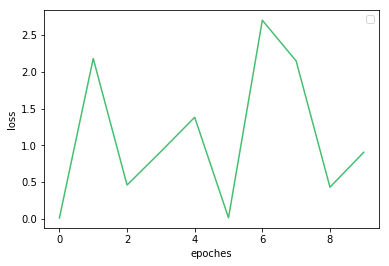

In [353]:
% matplotlib inline
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import shutil
import os

color = cm.viridis(0.7)
f, ax = plt.subplots(1,1)
epoches = [i for i in range(len(loss_p))]
ax.plot(epoches, loss_p, color=color)

ax.legend()
ax.set_xlabel('epoches')
ax.set_ylabel('loss')

plt.show()

##### TaskB
Since the data for taskB is imbalanced, add a weight for the loss of each sample according to its label during the training time:  
{label:weight}={0.0: 1.9907674552798615, 1.0: 2.7555910543130993, 2.0:12.23404255319149, 3.0: 18.852459016393443}

In [ ]:
def multiclass_acc(model, loader):
    model.eval()
    total_acc = 0
    for batch in loader:
        x, y = batch.text, batch.label - 1
        out = model(x)
        total_acc += 
    return total_acc / len(test_iter)

In [ ]:
model2 = SelfAttenClassifier(
    encoder = Encoder(EncoderLayer(dim_model,attn_layer,ff_layer),num_encoder_layers),
    classifier = SoftMax(dim_model,num_class=4),
    )

weight = torch.tensor([1.9907674552798615, 2.7555910543130993, 12.23404255319149, 18.852459016393443])
loss_function = F.nll_loss(weight)

time_p, tr_acc_array, ts_acc, loss_p = [], [], [], []
epochs = 10
# running epoches
for epoch in range(1, epochs + 1):
        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_start = time.perf_counter()

        train_loss = train(model, train_loader, loss_function,optimizer)
        train_acc = binary_acc(model, train_loader)

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_end = time.perf_counter()
        time_p.append(t_end)
        loss_p.append(train_loss)
        tr_acc_array.append(train_acc)

        print('Epoch: {:03d}, Acc: {:.8f}, Duration: {:.2f}'.format(
            epoch, train_acc, t_end - t_start))

# save model params
torch.save(model.state_dict(), 'taskA_transformer_params.pkl')

In [ ]:
f, ax = plt.subplots(1,1)
epoches = [i for i in range(len(loss_p))]
ax.plot(epoches, loss_p, color=color)

ax.legend()
ax.set_xlabel('epoches')
ax.set_ylabel('loss')

plt.show()

### Evaluation

##### validate

##### Visualization

In [ ]:
def attention_heatmap(model, dialog_vocab, candidate_vocab, memory, query, label=None):
    
    pred, attn = model(Variable(memory), Variable(query))
    
    attn = attn.squeeze(0).data.numpy()
    
    y_labels = []
    pad = dialog_vocab.word_to_index('<pad>')
    for row in memory.squeeze(0).numpy():
        row = row.tolist()
        end = len(row)
        if pad in row:
            end = row.index(pad)
        y_labels.append(vec2sent(dialog_vocab, row[2:end]))
    
    ax = plt.axes()
    ax.set_title('Attention Weights per Memory Hops')
    ax = sns.heatmap(attn, linewidths=.5, square=True, yticklabels=y_labels, ax=ax, cmap=sns.color_palette("Blues"))
    ax.set(xlabel='Hops', ylabel='Memory Contents')
    plt.show()
    
    if label:
        print('True label: ', candidate_vocab.index_to_word(label))
        print('Prediction: ', candidate_vocab.index_to_word(torch.max(pred.data, 1)[1][0]))

全self-attention层可能存在的问题：
- only capture the inner structure of a sentence, the relations between sentence parts and classification are not captured directly.
- position information is not sufficiently modeled.

因此经常self-attention层会和RNN/LSTM结合使用

#### Test
wirte predicted labels for test data:(one sample a line): label+\t+orinignal word list\n

#### Reference
- [The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html#position-wise-feed-forward-networks)
- [Multi-head Self Attention for Text Classification](https://www.kaggle.com/fareise/multi-head-self-attention-for-text-classification)

--代码参考--
- [BERT-pytorch](https://github.com/codertimo/BERT-pytorch]
- [Variable-sized mini-batches and why PyTorch is good for your health](https://towardsdatascience.com/taming-lstms-variable-sized-mini-batches-and-why-pytorch-is-good-for-your-health-61d35642972e)